$$$$$ Fetch Data ...
$$$$$ Plot Data ...
$$$$$ Apply K means to partition data ...
$$$$$ Apply Gaussian Mixture Model to partition data ...


GMM weights:  [0.34437518 0.33266661 0.32295821]

GMM means:  [[-2.20855668e-03 -2.62288466e-02]
 [ 2.63769009e-02  2.51487184e+00]
 [ 9.15503365e-01 -1.01298247e+00]]

GMM Covariance:  [[[ 0.02148284  0.02016493]
  [ 0.02016493  0.50000828]]

 [[ 0.53257517  0.00180825]
  [ 0.00180825  0.02165886]]

 [[ 0.62580978 -0.01692923]
  [-0.01692923  0.02127836]]]


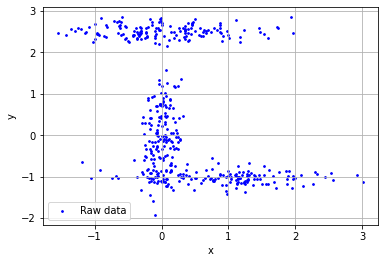

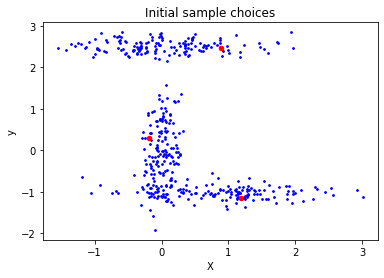

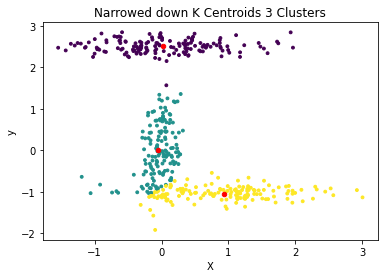

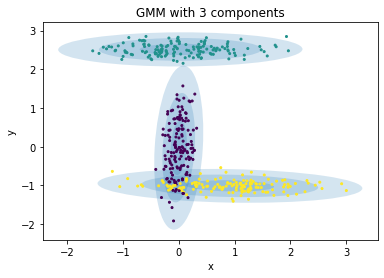

In [22]:
#The data was generated from a mixture of three Gaussians
# => Expect there to be three clusters in the data
import numpy as np
import matplotlib.pyplot as plt

print('$$$$$ Fetch Data ...')
data_ = np.loadtxt('cluster1.csv', delimiter=',')
np.random.seed(69) # The sequence is dictated by the random seed, which starts the process
np.random.shuffle(data_)
X = data_[:,0].reshape(-1,1)
y = data_[:,1].reshape(-1,1)

print('$$$$$ Plot Data ...')
fig, ax = plt.subplots()
ax.scatter(X, y, color='blue', marker='o', label='Raw data', s=3)
ax.set_ylabel('y')
ax.set_xlabel('x')
plt.legend()
plt.grid()
plt.show()
# Apply k-means to partition the data set into three clusters
print('$$$$$ Apply K means to partition data ...')
# We fix the number of clusters in advance and must guess where the centers are (called “centroids”).
# One measurement is the squared average distance of all the points within a cluster to the cluster centroid.
# i.e. the variability of the observations within each cluster.
def initialize_centroids(points, k):
    centroids = points.copy()
    np.random.seed(5)
    np.random.shuffle(centroids)
    return centroids[:k]

# Subtract each centroid from each point
# perform points - centroids, for each centroid. Therefore we need another dimension to store this (np.newaxis)
# Square distance and sum across the two columns
# np argmin: for each centroid, for each point, find the minimum index
def closest_centroid(points, centroids):
    distances = np.sqrt(((points - centroids[:, np.newaxis]) ** 2).sum(axis=2))
    return np.argmin(distances, axis=0) # index of the closest centroid

# move the centroids to the mean location
def move_centroids(points, closest, centroids):
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])


# Plot a graph of the resulting clusters.
plt.scatter(X, y, marker='o', color='blue', s=3)
initial = initialize_centroids(data_, 3)
plt.title('Initial sample choices')
plt.xlabel('X')
plt.ylabel('y')
plt.scatter(initial[:, 0], initial[:, 1], c='r', s=20)
plt.show()

# specify K cluster centroids
centroids = initialize_centroids(data_, k=3)
closest = closest_centroid(data_, centroids) # makes use of numpy broadcasting
centroids = move_centroids(data_, closest, centroids)

plt.scatter(X, y, c=closest, s=8)
plt.title('Narrowed down K Centroids 3 Clusters')
plt.xlabel('X')
plt.ylabel('y')
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=20)
plt.show()

# Use a Gaussian Mixture Model (GMM)
print('$$$$$ Apply Gaussian Mixture Model to partition data ...')
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, alfa):
    ax = plt.gca()
    U, s, Vt = np.linalg.svd(covariance)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    # Add ellipses to plot.
    for l in range(1, 4):
        ax.add_patch(Ellipse(position, l * width, l * height, angle, alpha=alfa))

def plot_gmm(gmm, ax=None):
    ax = ax or plt.gca()
    clusters = gmm.fit(data_).predict(data_)

    ax.scatter(X, y, c=clusters, s=4, cmap='viridis', zorder=2)
    # weight, mean, and covariance of each mixture component.
    w_ = 0.2 / gmm.weights_.max()
    for pos, covar, weight in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, weight * w_)
    # Plot clusters
    plt.title("GMM with 3 components")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


# allows each cluster to be modeled as an ellipse with arbitrary orientation
gmm = GMM(n_components=3, covariance_type="full").fit(data_)
print("\n\nGMM weights: ", gmm.weights_)
print("\nGMM means: ", gmm.means_)
print("\nGMM Covariance: ", gmm.covariances_)

plot_gmm(gmm)

## =========== examination =========== ##

# The plots at our disposal, demonstrate slight differences in classification but do capture the clusters in the data
# One difference is that k-means relies on centroid points to label and fails to distinguish the form when two clusters intersect
# Cluster 2 and 3 are vertical and horizontal respectively. Nevertheless K-means classifies the edge points to a different cluster
# Undoubtedly because at a certain distance from the centroid they become closer to a new cluster centroid.
# This result is not ideal.
# A better model should recognize that this is an intersection and correctly classifies the points.
# To use the gaussian mixture model which allows probabilistic cluster assignments
# we can fit our stretched dataset. To also allow for a "full" covariance type, our gmm model is equipped to fit oblong, stretched-out clusters
# like the ones at hand.
# In contrast, k-Means has no built-in way of accounting for oblong or elliptical clusters
# Instead for each point clusters are labeled using the closest centroid
# Here with GMM, a data point has a finite probability of belonging to every cluster, whereas, for K-means each point belongs to only one cluster.
# This is because the GMM is not a partition of the data: the assignments are treated as random draws from a distribution.
